In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

import pysal.lib.weights as weights
import access

from geopy.distance import distance,geodesic

GEODATA_PATH = 'data/geodata/'
OUTPUT_PATH = 'data/output/'

In [2]:
def get_coord_via_PSGC(psgc,df,psgc_col="Bgy_Code",coord_col="centroid"):
    cond = df[psgc_col].str.contains(psgc)
    lon = df.loc[cond,coord_col].x.values[0]
    lat = df.loc[cond,coord_col].y.values[0]
    return (lat,lon)

def to_coord_tuple(point):
    lon = point.x
    lat = point.y
    return (lat,lon)

def get_PSGC_via_index(index,df,col):
    return df.loc[index,col]

def get_coord_values_in(index,df,col):
    lon = df.loc[index,col].x
    lat = df.loc[index,col].y
    return (lat,lon)

def get_km_dist_two_coord_series(coords1,coords2):
    dists = []
    for coord1,coord2 in zip(coords1,coords2):
        dists.append(geodesic(coord1,coord2).km)
    return dists

In [3]:
crs_constant = "EPSG:4326"

brgys_geodata = gpd.read_file(GEODATA_PATH+'AdministrativeBoundariesBARMMBarangays20190206PSA2016/AdministrativeBoundariesBARMMBarangays20190206PSA2016.shp')
brgys_geodata = brgys_geodata.to_crs(crs_constant)

cond = brgys_geodata['Reg_Code']=='PH150000000'
brgys_geodata=brgys_geodata[cond].reset_index(drop=True)

brgys_geodata["centroid"] = brgys_geodata["geometry"].centroid
print("brgys_geodata",brgys_geodata.shape)

schools_geodata = gpd.read_file(OUTPUT_PATH+'SchoolsDepEd2017_Geodata_Clean/SchoolsDepEd2017_Geodata_Clean.shp')
schools_geodata = schools_geodata.to_crs(crs_constant)
schools_geodata.dropna(subset=["PSGC_BRGY"],inplace=True)

cond = (schools_geodata["geometry"].x>0) &(schools_geodata["geometry"].y>0)
schools_geodata = schools_geodata[cond].reset_index(drop=True)
print("schools_geodata",schools_geodata.shape)

brgys_geodata (2489, 10)
schools_geodata (2533, 13)


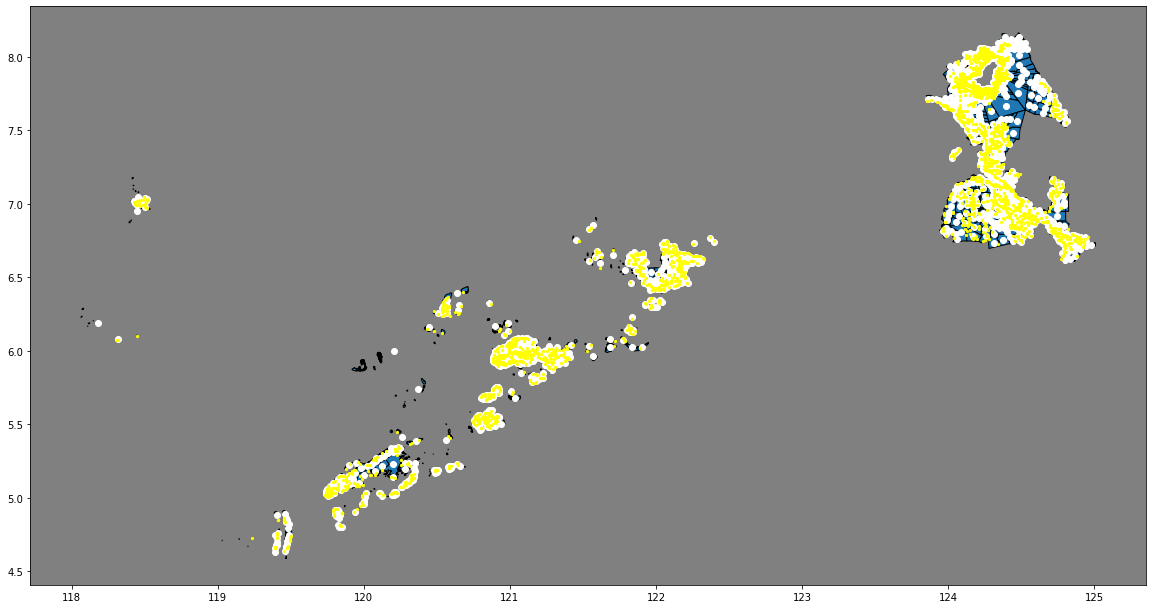

In [4]:
base = brgys_geodata.plot(figsize=(20,20),edgecolor='k')
brgys_geodata["centroid"].plot(ax=base,color="white")
schools_geodata.plot(ax=base,color="Yellow",markersize = 5)
base.set_facecolor('grey');

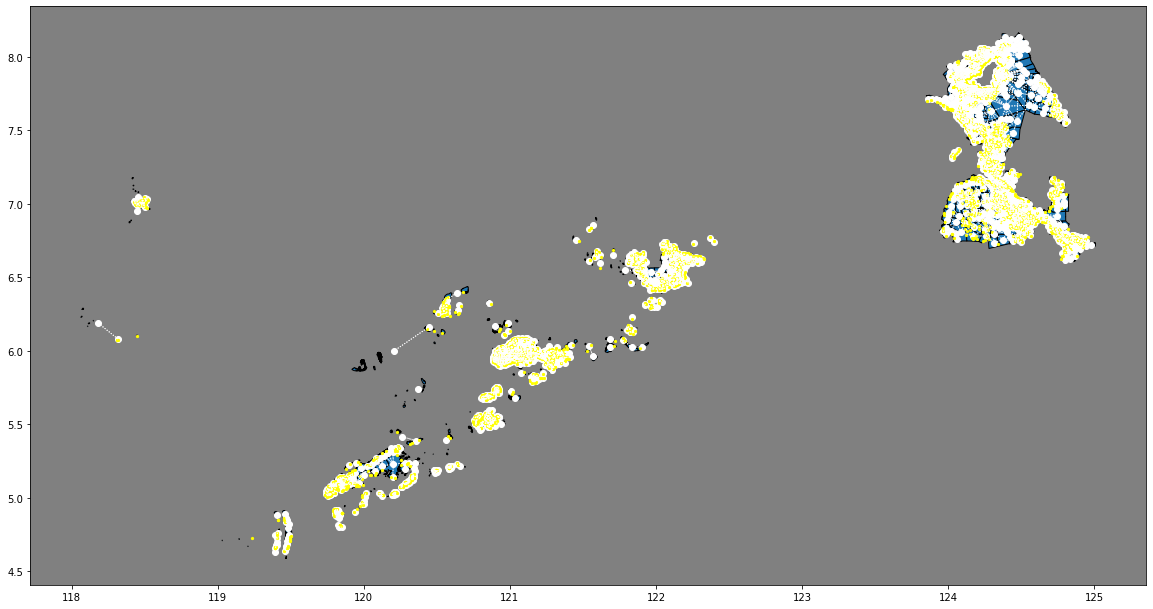

In [5]:
spatial_weights = weights.contiguity.Queen.from_dataframe(brgys_geodata)
base = brgys_geodata.plot(figsize=(20,20), edgecolor='k')
spatial_weights.plot(brgys_geodata, ax=base, 
        edge_kws=dict(color='white', linestyle=':', linewidth=1),
        node_kws=dict(marker=''))
brgys_geodata["centroid"].plot(ax=base,color="white")
schools_geodata.plot(ax=base,color="Yellow",markersize = 5)
base.set_facecolor('grey');

In [6]:
brgy_neighbors = spatial_weights.neighbors

brgy_source_targets = pd.DataFrame()

for source,targets in brgy_neighbors.items():
    if(len(targets)==0):
        targets=[source]
    
    brgy = {"source_index":source,"target_index":targets}
    
    brgy_source_targets = brgy_source_targets.append(pd.DataFrame(brgy))
    
brgy_source_targets["source_PSGC"] = brgy_source_targets["source_index"]\
                                        .apply(get_PSGC_via_index,df=brgys_geodata,col="Bgy_Code")
brgy_source_targets["target_PSGC"] = brgy_source_targets["target_index"]\
                                        .apply(get_PSGC_via_index,df=brgys_geodata,col="Bgy_Code")
brgy_source_targets["source_coords"] = brgy_source_targets["source_index"]\
                                        .apply(get_coord_values_in,df=brgys_geodata,col="centroid")

print("brgy_source_targets",brgy_source_targets.shape)

psgc_search_df = brgy_source_targets.groupby("source_PSGC",as_index=False)["target_PSGC"].apply(lambda x: "%s" % '|'.join(x))
cond = psgc_search_df["source_PSGC"]==psgc_search_df["target_PSGC"]
psgc_search_df.loc[~cond,"target_PSGC"] = psgc_search_df.loc[~cond,"source_PSGC"]+"|"+psgc_search_df.loc[~cond,"target_PSGC"]

print("psgc_search_df",psgc_search_df.shape)

brgy_source_targets (12910, 5)
psgc_search_df (2489, 2)


In [7]:
schools = schools_geodata[["SCH_ID","PSGC_BRGY","geometry"]]
schools.dropna(subset=["PSGC_BRGY"],inplace=True)

print("schools",schools.shape)

school_source_targets = pd.DataFrame()

no_schools_source = []

for source,targets in psgc_search_df.values:
    cond = schools["PSGC_BRGY"].str.contains(targets)
    
    if (sum(cond))==0:
        no_schools_source.append(source)
        continue
    
    _sub_df = schools[cond]
    _sub_df["source_PSGC"] = source
    school_source_targets = school_source_targets.append(_sub_df)
    
print(len(no_schools_source),"Brgys with No schools even in neighboring Brgys")
school_source_targets = school_source_targets.reset_index(drop=True)
print("school_source_targets",school_source_targets.shape)

school_source_targets["source_coords"] = school_source_targets["source_PSGC"]\
                                            .apply(get_coord_via_PSGC,df=brgys_geodata)

school_source_targets["target_coords"] = school_source_targets["geometry"].apply(to_coord_tuple)

school_source_targets["km_distance"] = get_km_dist_two_coord_series(school_source_targets["source_coords"],
                                                                    school_source_targets["target_coords"])
print("school_source_targets",school_source_targets.shape)

schools (2533, 3)
60 Brgys with No schools even in neighboring Brgys
school_source_targets (15522, 4)
school_source_targets (15522, 7)


In [8]:
cols = ["source_PSGC","SCH_ID","km_distance"]
cost_matrix = school_source_targets[cols]
cost_matrix["mins_travel_time"] = 60 * cost_matrix["km_distance"]/1 #km/hour
print("cost_matrix",cost_matrix.shape)

pop_brgy = pd.read_csv(OUTPUT_PATH+"CleanData_Population_Schools_SDGs.csv")
pop_brgy = pop_brgy[["PSGC_BRGY","both_age_6_to_16"]]
print("pop_brgy",pop_brgy.shape)


brgys = brgys_geodata[["Bgy_Code","geometry"]]
brgys = pd.merge(brgys,pop_brgy,left_on="Bgy_Code",right_on="PSGC_BRGY",how="left")
brgys = brgys[["PSGC_BRGY","geometry","both_age_6_to_16"]]
print("brgys",brgys.shape)

cost_matrix (15522, 4)
pop_brgy (2482, 2)
brgys (2489, 3)


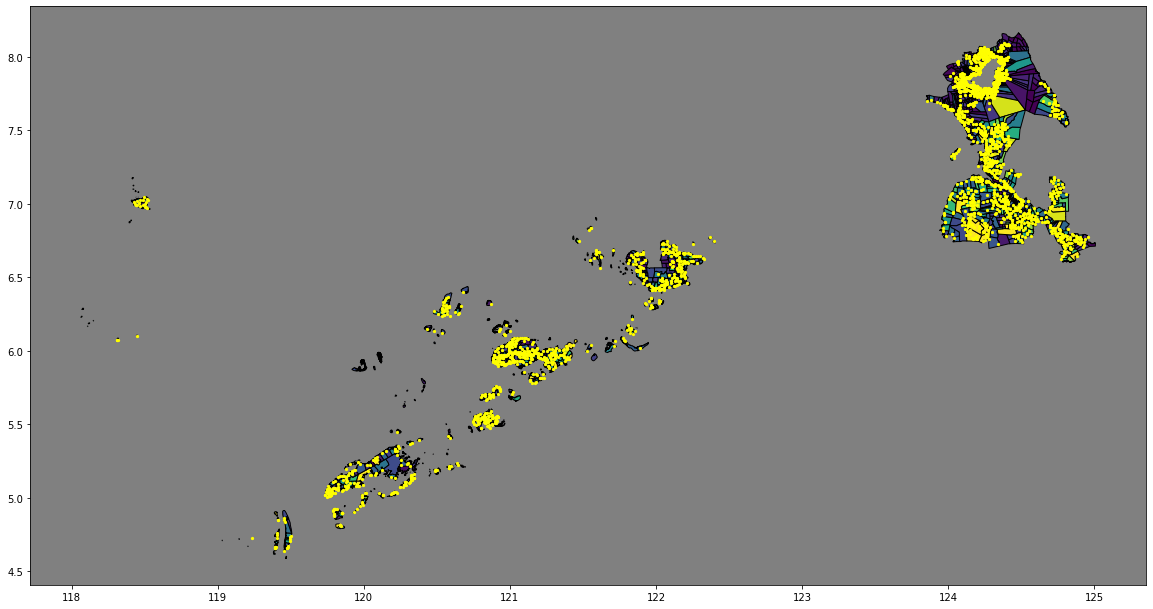

In [9]:
base = brgys.plot(figsize=(20,20),column="both_age_6_to_16",edgecolor='k',
                  vmin = brgys['both_age_6_to_16'].quantile(0.05), vmax = brgys['both_age_6_to_16'].quantile(0.95)
                 )
schools.plot(ax=base,color="Yellow",markersize = 5)
base.set_facecolor('grey');

In [10]:
brgys_w_schools = gpd.sjoin(schools, brgys[['PSGC_BRGY', 'geometry']],
                                  how='inner', op='intersects')
brgys_w_schools = brgys_w_schools.drop(columns=['index_right',"PSGC_BRGY_right"])
brgys_w_schools = brgys_w_schools.rename(columns={"PSGC_BRGY_left":"PSGC_BRGY"})

school_access = access.Access(demand_df    = brgys, 
                                demand_index = 'PSGC_BRGY', 
                                demand_value = 'both_age_6_to_16',
                                supply_df    = brgys_w_schools, 
                                supply_index = 'SCH_ID',
                                cost_df      = cost_matrix, 
                                cost_origin  = 'source_PSGC', 
                                cost_dest    = 'SCH_ID',
                                cost_name    = 'mins_travel_time')

gravity = access.weights.gravity(scale = 60, alpha = -1)
school_access.weighted_catchment(name = "gravity", weight_fn = gravity)

access INFO     :: Warning: A supply value was not provided, so a default
                             supply value of 1 was created in the column named "value".
                             Note that without a supply value, you cannot use any of the
                             floating catchment area methods.


,gravity_value
PH150702001,2.153343
PH150702002,2.545851
PH150702004,6.806820
PH150702005,3.751609
PH150702006,3.020273
...,...
NaN,NaN
NaN,NaN
NaN,NaN
NaN,NaN


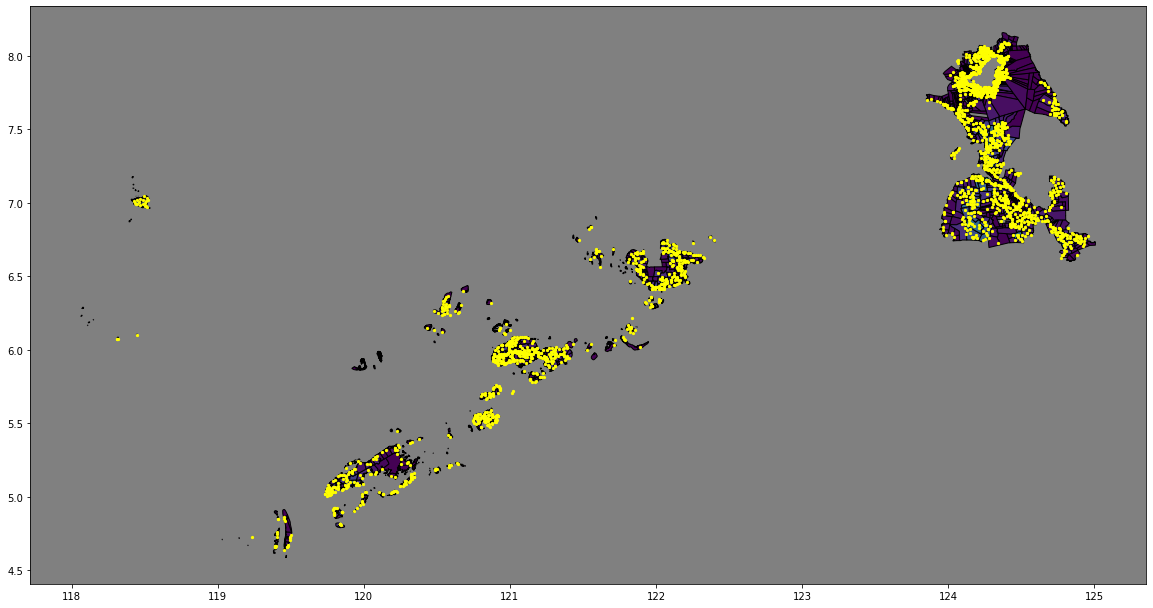

In [11]:
_map = brgys[["PSGC_BRGY","geometry"]].set_index('PSGC_BRGY').join(school_access.access_df, how = "inner")
base = _map.plot('gravity_value', figsize = (20, 20), alpha = 1,edgecolor='k',
                 vmin = _map['gravity_value'].quantile(0.05), vmax = _map['gravity_value'].quantile(0.95))
schools.plot(ax=base, color='yellow' ,markersize = 5)
base.set_facecolor('grey');

In [12]:
school_access_df = school_access.access_df.reset_index()
school_access_df = school_access_df.dropna(subset=["index"])
school_access_df.columns = ["PSGC_BRGY","Student_Popn_6_to_16","Access_Score"]
print("brgys",brgys.shape)
school_access_df.to_csv(OUTPUT_PATH+"Model_Access_Scores_General.csv",index=False)
school_access_df["Access_Score"].describe()

brgys (2489, 3)


count    2408.000000
mean        6.670316
std         9.858392
min         0.062535
25%         2.318874
50%         4.060306
75%         7.243614
max       123.648334
Name: Access_Score, dtype: float64